In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch
# from utility import get_all_files_paths

In [2]:
TRAIN = True

BETA = 1
BATCH_SIZE = 64
LATENT_SPACE_DIM = 1024
LEARNING_RATE = 1e-5

SAVE_ROUND = 20
NUM_EPOCHS = 300

torch.manual_seed(0) # random seed for reproducible results
# 似乎不同设备要单独设置随机种子？

In [3]:
dataset_path="data/spec/fma_small"
# dataset_path="data/spec/GTZAN_646"
model_save_path = "models/Echoes"
csv_save_path = "output/Echoes_output"

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f'device: {device}')

device: cuda


In [4]:
class MusicDataset(Dataset):
	def __init__(self, file_paths):
		self.file_paths = file_paths

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, idx):
		file_path = self.file_paths[idx]
		data = np.load(file_path)
	
		if np.isnan(data).any():
			filename = os.path.basename(file_path)
			label = filename.replace(".npy", "").lstrip("0")
			print(f"Warning: NaN value found in {label}")
  
		data = data[np.newaxis, :, :]  # Add a channel dimension
		data = torch.tensor(data, dtype=torch.float32)
		
		# filename = os.path.basename(os.path.dirname(file_path))
		filename = os.path.basename(file_path)
		label = filename.replace(".npy", "").lstrip("0")
		return data, label

file_paths = []
for root, dirs, files in os.walk(dataset_path):
	for file in files:
		file_paths.append(os.path.join(root, file))

# 取出20%的数据作为测试集，10%的数据作为验证集，剩下的作为训练集（理论上每个文件夹有风格区别，应该尽量做到比例均匀），但是（先验的）风格不好分，暂时直接随机划分

m = len(file_paths)
test_size = int(m * 0.15)
valid_size = int(m * 0.15)
train_size = m - test_size - valid_size
# train : valid : test = 70 : 15 : 15

paths = np.array(file_paths)
np.random.shuffle(paths)

train_paths = paths[:train_size]
valid_paths = paths[train_size:train_size + valid_size]
test_paths = paths[train_size + valid_size:]

train_dataset = MusicDataset(train_paths)
valid_dataset = MusicDataset(valid_paths)
test_dataset = MusicDataset(test_paths)

print(f'Training set size:   {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size:       {len(test_dataset)}')

if TRAIN:
	train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
	valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
	test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set size:   5597
Validation set size: 1198
Test set size:       1198


: 

In [ ]:
if TRAIN:
	loss_fn = torch.nn.MSELoss()
	
	encoder = Encoder(encoded_space_dim=LATENT_SPACE_DIM)
	decoder = Decoder(encoded_space_dim=LATENT_SPACE_DIM)
	params_to_optimize = [
		{'params': encoder.parameters()},
		{'params': decoder.parameters()}
	]

	optim = torch.optim.Adam(params_to_optimize, lr=LEARNING_RATE, weight_decay=1e-05)

	encoder = encoder.to(device)
	decoder = decoder.to(device)
	
	losses = {'train_loss':[],'val_loss':[]}

	for epoch in range(NUM_EPOCHS):
		# beta = epoch / NUM_EPOCHS  # Increase beta over time
		beta = BETA
		train_loss =train_epoch(encoder, decoder, device, train_loader, loss_fn, optim, beta)
		val_loss = test_epoch(encoder, decoder, device, valid_loader, loss_fn, beta)
	
		print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, NUM_EPOCHS,train_loss,val_loss))

		# track losses
		losses['train_loss'].append(train_loss)
		losses['val_loss'].append(val_loss)

		# save model
		if (epoch + 1) % SAVE_ROUND == 0: 
			torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
			torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	test_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn, beta)


 EPOCH 1/300 	 train loss 3834.090576171875 	 val loss 2338.12158203125

 EPOCH 2/300 	 train loss 1136.937255859375 	 val loss 977.5497436523438

 EPOCH 3/300 	 train loss 554.6588134765625 	 val loss 590.9544677734375

 EPOCH 4/300 	 train loss 353.0775146484375 	 val loss 403.0690612792969

 EPOCH 5/300 	 train loss 258.0640563964844 	 val loss 317.34429931640625


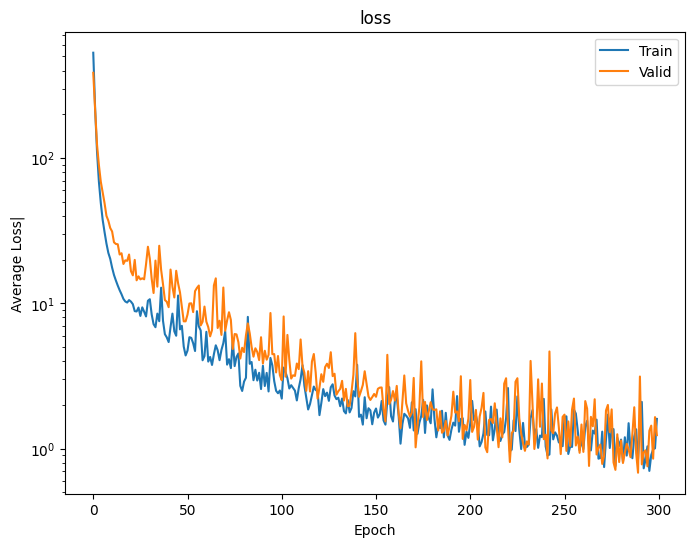

In [6]:
plt.figure(figsize=(8,6))
plt.semilogy(losses['train_loss'], label='Train')
plt.semilogy(losses['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss|')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [7]:
test_loss

np.float32(1.202567)

In [8]:
encoder_path = f"{model_save_path}/encoder.pth"
decoder_path = f"{model_save_path}/decoder.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

In [9]:
if not TRAIN:
	encoder_path = f"{model_save_path}/encoder_280.pth"
	encoder = load_encoder(encoder_path, LATENT_SPACE_DIM)
	encoder = encoder.to(device)

encoded_samples = []
for sample in tqdm(test_dataset):
	data = sample[0].unsqueeze(0).to(device)
	label = sample[1]
	encoder.eval()
	with torch.no_grad():
		mu, log_var = encoder(data)

	encoded_data = mu + torch.exp(0.5 * log_var) * torch.randn_like(mu)
	encoded_data = encoded_data.flatten().cpu().numpy()
	encoded_sample = {f"enc. v {i}": enc for i, enc in enumerate(encoded_data)}
	encoded_sample['label'] = label
	encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/fma_small_encoded.csv", index=False)
encoded_samples

100%|██████████| 1198/1198 [00:01<00:00, 619.52it/s]


,enc. v 0,enc. v 1,enc. v 2,enc. v 3,enc. v 4,enc. v 5,enc. v 6,enc. v 7,enc. v 8,enc. v 9,...,enc. v 119,enc. v 120,enc. v 121,enc. v 122,enc. v 123,enc. v 124,enc. v 125,enc. v 126,enc. v 127,label
0,1.267071,0.557535,1.933488,0.607687,-0.507625,-0.065194,1.262836,0.334279,0.398840,-0.786332,...,0.974827,-0.775441,0.632430,0.780671,-0.737876,0.619561,0.747117,0.075522,0.118650,69823
1,0.913393,0.294578,0.462831,0.436949,0.739640,-0.379486,-1.218633,0.166203,-0.662924,-0.479459,...,0.839239,-0.613266,-2.304832,-0.121532,2.095236,-1.674352,0.212656,-0.584325,-0.440442,27613
2,1.765215,-0.550936,1.417077,-0.668350,0.909759,1.453523,1.297142,-0.843208,-0.444542,-0.474645,...,-0.802629,0.398275,-1.287387,0.213128,-0.155009,-0.058109,-1.820238,1.151625,0.172773,122086
3,0.263315,1.791512,1.299514,0.572956,-1.714958,0.423965,-0.670873,1.599144,0.343550,0.641321,...,-0.005807,1.923015,0.244845,-0.559216,-0.133095,0.323835,0.373225,0.859520,1.454329,123001
4,1.959091,-0.581149,-1.603914,-0.409664,-0.401267,-0.415988,0.399413,-0.179442,0.824222,0.497533,...,-0.747455,0.143950,-1.165495,0.247319,2.283772,2.041273,1.338482,-0.449340,0.025274,16995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1.213363,-0.454112,0.933403,-0.971722,-1.192477,0.402795,-0.725831,-2.712915,1.284924,0.272936,...,-0.899229,0.398516,-1.841116,-0.980005,-2.787559,0.072610,0.123177,0.575490,-0.095816,60510
1194,1.910102,-0.490818,2.070613,-0.695808,1.655498,-0.637921,1.411062,-1.055320,1.429801,0.581129,...,0.147496,1.697469,-0.016463,-3.782520,-0.878423,-1.606032,1.783374,-1.839760,0.688989,45393
1195,-1.164336,0.153377,-1.651537,0.030886,0.853581,1.011858,-2.149471,1.154250,-0.553791,-1.014834,...,0.412893,-1.067768,1.445304,-2.062111,-1.551340,-1.029888,0.455111,0.828355,-2.206412,33461
1196,0.989579,-0.598327,2.333723,-1.620165,0.194544,1.704538,-1.596772,-0.022823,0.484193,0.103184,...,-1.581000,0.398684,1.286394,-1.124036,0.137591,0.112109,1.253671,-0.971235,-0.709230,706
